## imports

In [ ]:
# Pipelines imports
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve,roc_curve


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1.5, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend(loc="lower right", fontsize=16)


In [ ]:


data_path = os.path.join(os.path.curdir, 'data')
print(os.getcwd())
# loadit les csv
general_data_brute = pd.read_csv(os.path.join(data_path, 'general_data.csv'))
in_time_brute = pd.read_csv(os.path.join(data_path, 'in_time.csv'))
out_time_brute = pd.read_csv(os.path.join(data_path, 'out_time.csv'))
manager_survey_data_brute = pd.read_csv(
    os.path.join(data_path, 'manager_survey_data.csv'))
employee_survey_data_brute = pd.read_csv(
    os.path.join(data_path, 'employee_survey_data.csv'))


In [ ]:
pd.set_option('display.max_columns', None)


## Data Info

In [ ]:
general_data_brute.head()  # affichit head tae csv


In [ ]:
general_data_brute.describe()  # descriptit general data


In [ ]:
general_data_brute.info()  # affichit les infos ta3 chaque collone


In [ ]:
general_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()

# affichit histogramme tae dataset general


In [ ]:
manager_survey_data_brute.head()


In [ ]:
manager_survey_data_brute.describe()


In [ ]:
manager_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()


In [ ]:
employee_survey_data_brute.head()


In [ ]:
employee_survey_data_brute.describe()


In [ ]:
employee_survey_data_brute.hist(bins=20, figsize=(20, 15))
plt.show()


## Pre-traitement

In [ ]:
general_data = general_data_brute.drop('Over18', axis=1)
general_data = general_data.drop('StandardHours', axis=1)
general_data = general_data.drop('EmployeeCount', axis=1)


# deletit zoudj les collone


In [ ]:
general_data.head()


In [ ]:
in_time_brute.head()


In [ ]:
out_time = out_time_brute.copy()
out_time['employee_id'] = out_time[out_time.columns[0]]
out_time = out_time.drop(out_time.columns[0], axis=1)
# segemt la collone li ma 3ndhach asem


In [ ]:
in_time = in_time_brute.copy()
in_time['employee_id'] = in_time[in_time.columns[0]]
in_time = in_time.drop(in_time.columns[0], axis=1)

# segemt la collone li ma 3ndhach asem


In [ ]:
free_days = []
for col in in_time.columns:
    if in_time[col].isna().all():
        in_time = in_time.drop(col, axis=1)
        out_time = out_time.drop(col, axis=1)

# nehit les jours ferié


In [ ]:
out_time.head()


In [ ]:
# count work hours for each employee
from datetime import datetime, timedelta
employees_hours = []
additional_hours = []
minus_hours = []
abscences = []
for index, row in general_data.iterrows():
    employee_id = row['EmployeeID']
    in_time_employee = in_time[in_time['employee_id']
                               == employee_id].values[0]
    out_time_employee = out_time[out_time['employee_id']
                                 == employee_id].values[0]
    out_time_employee = out_time_employee[:-1]
    in_time_employee = in_time_employee[:-1]
    abscence = np.count_nonzero(in_time_employee == 'NaN')
    abscences.append(abscence)
    now = datetime.now()
    in_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in in_time_employee])
    out_time_employee = np.array([datetime.strptime(
        x, '%Y-%m-%d %H:%M:%S') if not pd.isna(x) else now for x in out_time_employee])

    employee_hours = out_time_employee - in_time_employee
    employee_hours = [x.total_seconds() for x in employee_hours]
    employee_hours = sum(employee_hours)
    employees_hours.append(employee_hours/(60**2))
    nb_day = len(out_time_employee)
    additional_hour = ((8*(nb_day))-employee_hours/(60**2))
    if additional_hour < 0:
        additional_hour = 0
        minus_hour = -1 * additional_hour
    else:
        minus_hour = 0

    additional_hours.append(additional_hour)
    minus_hours.append(minus_hour)
general_data['worked_hour'] = employees_hours
general_data['additional_hour'] = additional_hours


In [ ]:
np.count_nonzero(abscences)


In [ ]:
general_data['worked_hour']


In [ ]:
general_data.describe()


In [ ]:
general_data = pd.merge(
    general_data, employee_survey_data_brute, on="EmployeeID", how='left')
general_data

# dert join bin general_data w survey_employee


In [ ]:
general_data = pd.merge(
    general_data, manager_survey_data_brute, on="EmployeeID", how="left")
general_data['WorkLifeBalance']
# dert join bin general_data w manager_employee


In [ ]:
general_data.hist(bins=20, figsize=(20, 15))


In [ ]:
ordinal_columns = [
    'Attrition',
    'Gender',
]
onehot_columns = [
    'Department',
    'EducationField',
    'JobRole',
    'MaritalStatus',
]

one_hot_cat = []

for col in onehot_columns:
    one_hot_cat.append(general_data[col].unique())


bussiness_travel_values = ['Non-Travel', 'Travel_Rarely', 'Travel_Frequently']
fill_only_col = [
    "EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance", 'NumCompaniesWorked']

numeric_cols = [
    'Age',
    'TotalWorkingYears',
    'worked_hour',
    'additional_hour',
    'DistanceFromHome',
    'MonthlyIncome',
    'PercentSalaryHike',
    'StockOptionLevel',
    'TrainingTimesLastYear',
    'YearsAtCompany',
    'YearsSinceLastPromotion',
    'YearsWithCurrManager',
]


In [ ]:
one_hot_cat

In [ ]:
general_data['WorkLifeBalance'] = general_data['WorkLifeBalance'].astype(float)
general_data['EnvironmentSatisfaction'] = general_data['EnvironmentSatisfaction'].astype(
    float)
general_data['JobSatisfaction'] = general_data['JobSatisfaction'].astype(float)
general_data['NumCompaniesWorked'] = general_data['NumCompaniesWorked'].astype(
    float)
general_data['TotalWorkingYears'] = general_data['TotalWorkingYears'].astype(
    float)


In [ ]:
numeric_pipline = Pipeline([
    ('fill_na_num', SimpleImputer(strategy='median')),
    ('standardisation', StandardScaler()),
])
col_transformer = ColumnTransformer([
    ('fill_na', SimpleImputer(strategy='median'), fill_only_col),
    ('numeric', numeric_pipline, numeric_cols),
    ("qualitative", OneHotEncoder(categories=one_hot_cat), onehot_columns),
    ('bool', OrdinalEncoder(dtype=int), ordinal_columns),
    ("BusinessTravel", OrdinalEncoder(categories=[
     bussiness_travel_values]), ['BusinessTravel'])
])


In [ ]:
pre_general_data = col_transformer.fit_transform(general_data)


In [ ]:
copy_general_data = general_data.copy()


In [ ]:
start = 0

In [ ]:
for col in fill_only_col:
    general_data[col] = pre_general_data[:, start]
    start+=1

In [ ]:
for col in numeric_cols:
    general_data[col] = pre_general_data[:, start]
    start+=1


In [ ]:

for col in onehot_columns:
    for v in general_data[col].unique():
        general_data[v] = pre_general_data[:, start]
        general_data[v] = general_data[v].astype(int)
        start += 1
    general_data = general_data.drop(col, axis=1)


In [ ]:
for col in ordinal_columns:
    general_data[col] = pre_general_data[:, start]
    general_data[col] = general_data[col].astype(int)
    start += 1
    

In [ ]:
general_data['BusinessTravel'] = pre_general_data[:, start]
general_data['BusinessTravel'] = general_data['BusinessTravel'].astype(int)


In [ ]:
general_data.tail(5)

In [ ]:
corr_matrix = general_data.corr()
corr_matrix.style.background_gradient(cmap='Wistia')


In [ ]:
import seaborn as sn 
plt.figure(figsize=(8,15))
corr_matrix = corr_matrix.sort_values(by='Attrition', ascending=False)
sn.heatmap(corr_matrix[['Attrition']],annot=True,cmap='Wistia',center=0,vmax=0.3)

## Split

In [ ]:
general_data = general_data.drop("EmployeeID",axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(general_data, general_data["Attrition"]):
    strat_train_set = general_data.loc[train_index]
    strat_test_set = general_data.loc[test_index]


In [ ]:
y_train = strat_train_set['Attrition']
x_train = strat_train_set.drop('Attrition',axis=1)

In [ ]:
y_test = strat_test_set['Attrition']
x_test = strat_test_set.drop('Attrition',axis=1)

In [ ]:
x_train.isna().sum()

## Stochastic Gradient chkoupi 

In [ ]:
sgd_clf = SGDClassifier(max_iter=500, random_state=42)
sgd_clf.fit(x_train, y_train)
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train, cv=5)
print("precision : " + str(precision_score(y_train, y_train_pred))[2:4] + "%")
print("recall : " + str(recall_score(y_train, y_train_pred))[2:4] + "%")
print('F1 : ' + str(f1_score(y_train, y_train_pred))[2:4] + "%")
print('Accuracy : ' + str(accuracy_score(y_train, y_train_pred))[2:4] + "%")
cm = sn.heatmap(confusion_matrix(y_train, y_train_pred),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')
y_scores_sgd = cross_val_predict(
    sgd_clf, x_train, y_train, cv=5, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_sgd)
fig, ax = plt.subplots()
ax.plot(thresholds, precisions[:-1], "b-", label="Precision", linewidth=2)
ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1])
plt.show()
fpr_sdg,tpr_sdg, thresholds = roc_curve(y_train, y_scores_sgd)
plot_roc_curve(fpr_sdg, tpr_sdg, "SDG")


In [ ]:
y_test_pred_sgd = sgd_clf.predict(x_test)
y_test_scores_sgd = sgd_clf
# y_test_pred_sgd = y_test_pred_sgd > best_threshold_sgd
print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_sgd)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_sgd)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_sgd)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_sgd)*100), "%")
fpr_sgd,tpr_sgd, thresholds = roc_curve(y_train, y_scores_sgd)
plot_roc_curve(fpr_sgd, tpr_sgd, "SDG")


In [ ]:
param_grid_sgd = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [200,300,400,500],
    'tol': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
}

grid_search_sgd = GridSearchCV(sgd_clf, param_grid_sgd, cv=7,
                                  scoring='accuracy', return_train_score=True)
grid_search_sgd.fit(x_train, y_train)


In [ ]:
sgd_clf = grid_search_sgd.best_estimator_
print(sgd_clf)
y_pred_sgd = cross_val_predict(sgd_clf, x_train, y_train, cv=5)
print("precision : " +
      "{:.2f}".format(precision_score(y_train, y_pred_sgd)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_train, y_pred_sgd)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_sgd)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_train, y_pred_sgd)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_sgd), annot=True, vmax=150 , fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')
y_scores_sgd = cross_val_predict(sgd_clf, x_train, y_train, cv=5,method='decision_function')

precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(
    y_train, y_scores_sgd)
fig, ax = plt.subplots()
ax.plot(thresholds_sgd, precisions_sgd[:-1],
        "b-", label="Precision", linewidth=2)
ax.plot(thresholds_sgd,
        recalls_sgd[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([-6, 2])
plt.show()
fpr_sgd,tpr_sgd, thresholds = roc_curve(y_train, y_scores_sgd)
plot_roc_curve(fpr_sgd,tpr_sgd, "SDG")


In [ ]:
y_test_pred_sgd = sgd_clf.predict(x_test)
y_test_scores_sgd = sgd_clf.decision_function(x_test)
y_test_pred_sgd = y_test_scores_sgd > 1.18
print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_sgd)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_sgd)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_sgd)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_sgd)*100), "%")
fpr_sgd,tpr_sgd, thresholds = roc_curve(y_train, y_scores_sgd)
plot_roc_curve(fpr_sgd,tpr_sgd, "SDG")



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=25, random_state=42)
forest_clf.fit(x_train,y_train)
y_pred_forest = cross_val_predict(forest_clf, x_train, y_train, cv=5)
print("precision : " + "{:.2f}".format(precision_score(y_train, y_pred_forest)*100) , "%")
print("recall : " + "{:.2f}".format(recall_score(y_train, y_pred_forest)*100) , "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_forest)*100) , "%")
print('Accuracy : ' + "{:.2f}".format(accuracy_score(y_train, y_pred_forest)*100) , "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_forest),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')


y_scores_forest = cross_val_predict(
    forest_clf, x_train, y_train.tolist(), cv=5, method="predict_proba")

y_scores_forest = y_scores_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)
fig, ax = plt.subplots()

ax.plot(thresholds_forest, precisions_forest[:-1],
         "b-", label="Precision", linewidth=2)
ax.plot(thresholds_forest,
         recalls_forest[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 1])
plt.show()
tpr_forest, fpr_forest, thresholds = roc_curve(y_train, y_scores_forest)
plot_roc_curve(tpr_forest, fpr_forest, "random forest")


In [ ]:
param_grid_forest = {
    'n_estimators': [350,400,500],
    'max_depth': [ 20, 30, 40]
}

grid_search_forest = GridSearchCV(forest_clf, param_grid_forest, cv=10,
                               scoring='accuracy', return_train_score=True)
grid_search_forest.fit(x_train, y_train)


In [ ]:
forest_clf = grid_search_forest.best_estimator_
print(forest_clf)
y_pred_forest = cross_val_predict(forest_clf, x_train, y_train, cv=10)
print("precision : " + "{:.2f}".format(precision_score(y_train, y_pred_forest)*100), "%")
print("recall : " + "{:.2f}".format(recall_score(y_train, y_pred_forest)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_forest)*100), "%")
print('Accuracy : ' + "{:.2f}".format(accuracy_score(y_train, y_pred_forest)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_forest),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')

y_scores_forest = cross_val_predict(
    forest_clf, x_train, y_train.tolist(), cv=5, method="predict_proba")

y_scores_forest = y_scores_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train, y_scores_forest)

fig, ax = plt.subplots()
ax.plot(thresholds_forest, precisions_forest[:-1],
         "b-", label="Precision", linewidth=2)
ax.plot(thresholds_forest,
         recalls_forest[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([0.1, 0.9])
plt.show()
fpr_forest,tpr_forest, thresholds = roc_curve(y_train, y_scores_forest)
plot_roc_curve(fpr_forest,tpr_forest, "random forest")


In [ ]:
y_test_pred_forest = forest_clf.predict(x_test)
y_test_scores_forest = forest_clf.predict_proba(x_test)
# y_test_pred_forest = y_test_scores_forest[:,-1] > 0.
print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_forest)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_forest)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_forest)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_forest)*100), "%")
fpr_forest,tpr_forest, thresholds = roc_curve(y_train, y_scores_forest)
plot_roc_curve(fpr_forest,tpr_forest, "SDG")

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000,random_state=42)
y_pred_logreg = cross_val_predict(logreg,x_train,y_train,cv=5)
print("precision : " + str(precision_score(y_train, y_pred_logreg))[2:4] + "%")
print("recall : " + str(recall_score(y_train, y_pred_logreg))[2:4] + "%")
print('F1 : ' + str(f1_score(y_train, y_pred_logreg))[2:4] + "%")
print('Accuracy : ' + str(accuracy_score(y_train, y_pred_logreg))[2:4] + "%")
y_scores_logreg = cross_val_predict(
    logreg, x_train, y_train, cv=5, method="decision_function")
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(
    y_train, y_scores_logreg)

plt.plot(thresholds_logreg, precisions_logreg[:-1],
         "b-", label="Precision", linewidth=2)
plt.plot(thresholds_logreg,
         recalls_logreg[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.ylim([0, 1])
plt.show()
fpr_logreg,tpr_logreg, thresholds = roc_curve(y_train, y_scores_logreg)
plot_roc_curve(fpr_logreg,tpr_logreg, "logistic regression")

In [ ]:
param_grid_logreg = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.1, 0.01,0.001],
    'max_iter':[100,150,200,500]
}
grid_search_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5,scoring='accuracy', return_train_score=True)
grid_search_logreg.fit(x_train, y_train)


In [ ]:
logreg = grid_search_logreg.best_estimator_
print(logreg)
y_pred_logreg = cross_val_predict(logreg, x_train, y_train, cv=5)
print("precision : " +
      "{:.2f}".format(precision_score(y_train, y_pred_logreg)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_train, y_pred_logreg)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_logreg)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_train, y_pred_logreg)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_logreg),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')


y_scores_logreg = cross_val_predict(
    logreg, x_train, y_train.tolist(), cv=5, method="predict_proba")

y_scores_logreg = y_scores_logreg[:, 1]
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(
    y_train, y_scores_logreg)

fig, ax = plt.subplots()
ax.plot(thresholds_logreg, precisions_logreg[:-1],
        "b-", label="Precision", linewidth=2)
ax.plot(thresholds_logreg,
        recalls_logreg[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 0.9])
plt.show()
fpr_logreg, tpr_logreg, thresholds = roc_curve(y_train, y_scores_logreg)
plot_roc_curve(fpr_logreg, tpr_logreg, "log reg")


In [ ]:
y_test_pred_logreg = logreg.predict(x_test)
y_test_scores_logreg = logreg.predict_proba(x_test)
# y_test_pred_logreg = y_test_scores_logreg[:,-1] > 0.8
print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_logreg)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_logreg)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_logreg)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_logreg)*100), "%")
fpr_logreg,tpr_logreg, thresholds = roc_curve(y_train, y_scores_logreg)
plot_roc_curve(fpr_logreg,tpr_logreg, "SDG")

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(random_state=42, max_features=40, criterion="gini")
dtc.fit(x_train,y_train)
y_pred_dtc = cross_val_predict(dtc,x_train,y_train,cv=5)
print("Precision : " + "{:.2f}".format(precision_score(y_train, y_pred_dtc)*100), "%")
print("Recall : " + "{:.2f}".format(recall_score(y_train, y_pred_dtc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_dtc)*100), "%")
print('Accuracy : ' + "{:.2f}".format(accuracy_score(y_train, y_pred_dtc)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_dtc), annot=True, vmax=150 , fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')
y_scores_dtc = cross_val_predict(
    dtc, x_train, y_train, cv=5, method="predict_proba")
y_scores_dtc = y_scores_dtc[:, 1]
precisions_dtc, recalls_dtc, thresholds_dtc = precision_recall_curve(
    y_train, y_scores_dtc)
fig, ax = plt.subplots()
ax.plot(thresholds_dtc, precisions_dtc[:-1],
         "b-", label="Precision", linewidth=2)
ax.plot(thresholds_dtc,
         recalls_dtc[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="lower right", fontsize=16)
ax.set_ylim([0, 1.25])
ax.set_xlim([0, 1])
plt.show()
fpr_dtc,tpr_dtc, thresholds = roc_curve(y_train, y_scores_dtc)
plot_roc_curve(fpr_dtc,tpr_dtc, "decision tree")

In [ ]:
param_grid_dtc = {
    'max_depth': [4, 5, 7,10],
    'min_samples_split': [1,2, 5, 10],
    'min_samples_leaf': [1, 2, 4,5],
    'max_features': list(range(5, 40))
}

grid_search_dtc = GridSearchCV(dtc, param_grid_dtc, cv=5,
                               scoring='accuracy', return_train_score=True)
grid_search_dtc.fit(x_train, y_train)


In [ ]:
dtc = grid_search_dtc.best_estimator_
print(dtc)
y_pred_dtc = cross_val_predict(dtc, x_train, y_train, cv=5)
print("precision : " +
      "{:.2f}".format(precision_score(y_train, y_pred_dtc)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_train, y_pred_dtc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_dtc)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_train, y_pred_dtc)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_dtc), annot=True, vmax=150 , fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')

y_scores_dtc = cross_val_predict(
    dtc, x_train, y_train.tolist(), cv=5, method="predict_proba")

y_scores_dtc = y_scores_dtc[:, 1]
precisions_dtc, recalls_dtc, thresholds_dtc = precision_recall_curve(
    y_train, y_scores_dtc)

fig, ax = plt.subplots()
ax.plot(thresholds_dtc, precisions_dtc[:-1],
        "b-", label="Precision", linewidth=2)
ax.plot(thresholds_dtc,
        recalls_dtc[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 1])
plt.show()
fpr_dtc, tpr_dtc, thresholds = roc_curve(y_train, y_scores_dtc)
plot_roc_curve(fpr_dtc, tpr_dtc, "Decision Tree")


In [ ]:
y_test_pred_dtc = dtc.predict(x_test)
y_test_scores_dtc = dtc.predict_proba(x_test)
y_test_pred_dtc = y_test_scores_dtc[:,-1] > 0.9

print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_dtc)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_dtc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_dtc)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_dtc)*100), "%")
fpr_dtc,tpr_dtc, thresholds = roc_curve(y_train, y_scores_dtc)
plot_roc_curve(fpr_dtc,tpr_dtc, "Decision Tree")

## SVC

In [ ]:
from sklearn.svm import SVC

svc = SVC(random_state=42, C=1 ,probability=True)
svc.fit(x_train,y_train)
y_pred_svc = cross_val_predict(svc,x_train,y_train,cv=5)
print("Precision : " + "{:.2f}".format(precision_score(y_train, y_pred_svc)*100), "%")
print("Recall : " + "{:.2f}".format(recall_score(y_train, y_pred_svc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_svc)*100), "%")
print('Accuracy : ' + "{:.2f}".format(accuracy_score(y_train, y_pred_svc)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_svc),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')
y_scores_svc = cross_val_predict(
    svc, x_train, y_train, cv=5, method="predict_proba")
y_scores_svc = y_scores_svc[:, 1]
precisions_svc, recalls_svc, thresholds_svc = precision_recall_curve(
    y_train, y_scores_svc)
fig, ax = plt.subplots()
ax.plot(thresholds_svc, precisions_svc[:-1],
         "b-", label="Precision", linewidth=2)
ax.plot(thresholds_svc,
         recalls_svc[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="lower right", fontsize=16)
ax.set_ylim([0, 1.25])
ax.set_xlim([0, 1])
plt.show()
fpr_svc,tpr_svc, thresholds = roc_curve(y_train, y_scores_svc)
plot_roc_curve(fpr_svc,tpr_svc, "decision tree")

In [ ]:
param_grid_svc = {
        'C': [10,100,150],
}

grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5,
                               scoring='accuracy', return_train_score=True)
grid_search_svc.fit(x_train, y_train)


In [ ]:
svc = grid_search_svc.best_estimator_
print(svc)
y_pred_svc = cross_val_predict(svc, x_train, y_train, cv=5)
print("precision : " +
      "{:.2f}".format(precision_score(y_train, y_pred_svc)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_train, y_pred_svc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_train, y_pred_svc)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_train, y_pred_svc)*100), "%")

cm = sn.heatmap(confusion_matrix(y_train, y_pred_svc),
                annot=True, vmax=150, fmt=".0f")
cm.set_xlabel('Predicted labels')
cm.set_ylabel('True labels')

y_scores_svc = cross_val_predict(
    svc, x_train, y_train.tolist(), cv=5, method="predict_proba")

y_scores_svc = y_scores_svc[:, 1]
precisions_svc, recalls_svc, thresholds_svc = precision_recall_curve(
    y_train, y_scores_svc)

fig, ax = plt.subplots()
ax.plot(thresholds_svc, precisions_svc[:-1],
        "b-", label="Precision", linewidth=2)
ax.plot(thresholds_svc,
        recalls_svc[:-1], "g-", label="Recall", linewidth=2)
ax.set_xlabel("Threshold", fontsize=16)
ax.legend(loc="upper left", fontsize=16)
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 1])
plt.show()
fpr_svc, tpr_svc, thresholds = roc_curve(y_train, y_scores_svc)
plot_roc_curve(fpr_svc, tpr_svc, "SVC")


In [ ]:
best_threshold_svc = 0.5

In [ ]:
y_test_pred_svc = svc.predict(x_test)
y_test_scores_svc = svc.predict_proba(x_test)
y_test_pred_svc = y_test_scores_svc[:, -1] > best_threshold_svc

print("precision : " +
      "{:.2f}".format(precision_score(y_test, y_test_pred_svc)*100), "%")
print("recall : " +
      "{:.2f}".format(recall_score(y_test, y_test_pred_svc)*100), "%")
print('F1 : ' + "{:.2f}".format(f1_score(y_test, y_test_pred_svc)*100), "%")
print('Accuracy : ' +
      "{:.2f}".format(accuracy_score(y_test, y_test_pred_svc)*100), "%")
fpr_svc,tpr_svc, thresholds = roc_curve(y_train, y_scores_svc)
plot_roc_curve(fpr_svc,tpr_svc, "SVC")

## Comparer les modeles

In [ ]:
plot_roc_curve(fpr_sgd,tpr_sgd, "Gradient")
plot_roc_curve(fpr_logreg,tpr_logreg, "LOG Reg")
plot_roc_curve(fpr_forest,tpr_forest, "RFC")
plot_roc_curve(fpr_dtc,tpr_dtc, "DTC")
plot_roc_curve(fpr_svc,tpr_svc, "SVC")
plt.figure(figsize=(50,50))

In [ ]:
model_names = ['SGD','forest', 'LOG Reg', 'DTC','SVC']


In [ ]:
# graph accuracy bar
# 


accuracies = [
    85.83,
    99.43,
    85.49,
    94.56,
    99.09
]
plt.bar(model_names, accuracies)

# Set the title and axis labels
plt.title('Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Display the plot
plt.show()

In [ ]:
# graph recall bar

recalls = [
    15.49,
    96.48,
    23.24,
    76.06,
    97.89
]
plt.bar(model_names, recalls)

# Set the title and axis labels
plt.title('Model recalls')
plt.xlabel('Model')
plt.ylabel('recalls')

# Display the plot
plt.show()


In [ ]:
# graph F1  bar
f1s = [
    26.04,
    98.21,
    34.02,
    81.82,
    97.20
]
plt.bar(model_names, recalls)

# Set the title and axis labels
plt.title('Model F1')
plt.xlabel('Model')
plt.ylabel('F1')

# Display the plot
plt.show()


In [ ]:
# graph precision bar
precisions = [
    81.48,
    100,
    63.46,
    88.52,
    96.53,
]

plt.bar(model_names, recalls)

# Set the title and axis labels
plt.title('Model precisions')
plt.xlabel('Model')
plt.ylabel('Precision')

# Display the plot
plt.show()


## determiner les parametres les plus influent

In [ ]:
support_vectors = svc.support_vectors_


Text(0.5, 0, 'Permutation Importance')

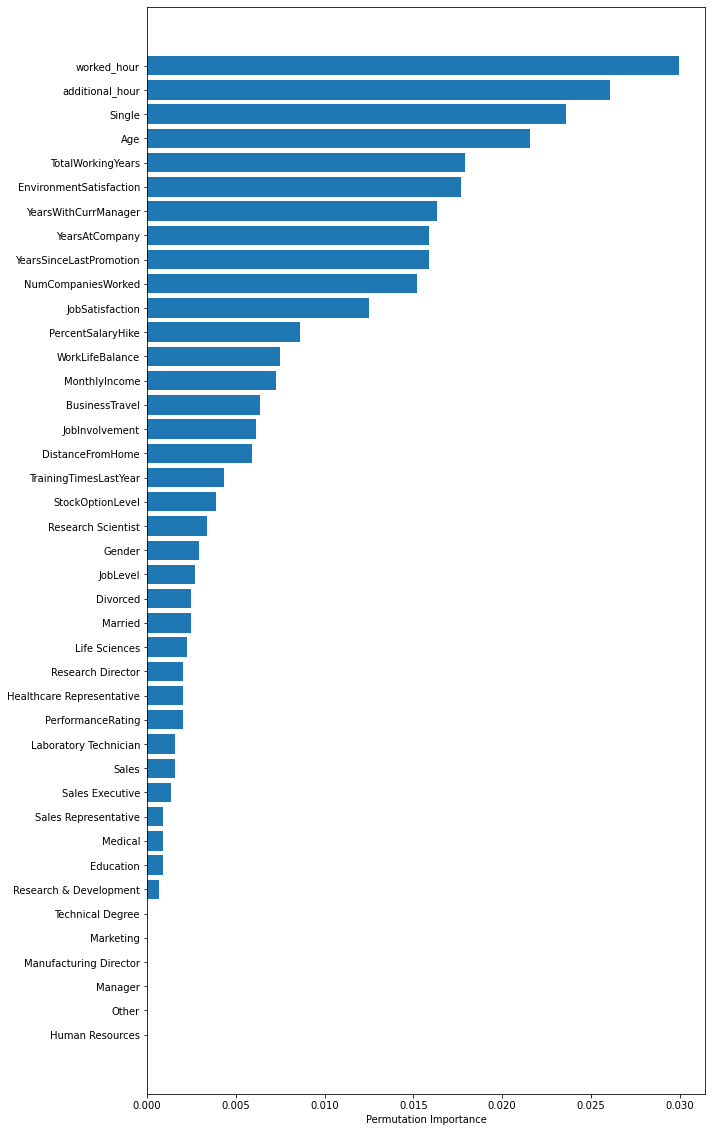

In [161]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(forest_clf, x_test, y_test)
feature_names = x_test.columns
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 20))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
#plt.xticks(rotation=45)
plt.xlabel("Permutation Importance")


## Appliquer des modifications au dataset de base

avant:  16.10 %
apres:  9.30 %


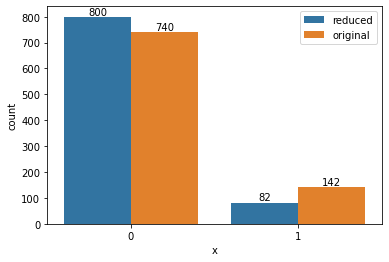

In [164]:
x_test_age_reduced = x_test.copy()
x_test_age_reduced['Age'] = x_test['Age'] * 0.8
x_test_age_reduced['TotalWorkingYears'] = x_test['TotalWorkingYears']*0.8
x_test_age_reduced['worked_hour'] = x_test['worked_hour']*0.8
x_test_age_reduced['additional_hour'] = x_test['additional_hour']*0.5
# x_test_age_reduced['NumCompaniesWorked'] = x_test['NumCompaniesWorked']
y_test_age_reduced = forest_clf.predict(x_test_age_reduced)

df = pd.DataFrame()
df['x'] = np.concatenate((y_test_age_reduced, y_test))
df['hue'] = np.concatenate(
    (np.full(len(y_test_age_reduced), 'reduced'), np.full(len(y_test), 'original')))
ax = sn.countplot(data=df, x='x', hue='hue')
for container in ax.containers:
    ax.bar_label(container)
# Add a legend to the plot
plt.legend()
print("avant: ","{:.2f}".format(np.count_nonzero(y_test)*100/len(y_test)),"%")
print("apres: ","{:.2f}".format(np.count_nonzero(y_test_age_reduced)*100/len(y_test_age_reduced)),"%")
